In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
import pyresample
import warnings
warnings.filterwarnings('ignore')

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
# define basin we want - here 6 is for Barents
# we can look directly at the layers output if we want to:
#  cd /scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

# write the wet mask and also set to nan
wetmask = mygrid['hFacC']
print(wetmask.shape)
wetmask_tracer = get_aste_tracer(wetmask,nfx,nfy)
print("hey",wetmask_tracer.shape)
wetmask_tracer[:,450:,:270] = np.nan
wetmask = aste_tracer2compact(wetmask_tracer,nfx,nfy)
print(wetmask.shape)

dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

(50,) (50, 1350, 270)
hf1 (1350, 270)
shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)
(50, 1350, 270)
hey (50, 900, 540)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 1350, 270)


In [3]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.arange(12,13,1)
times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

In [4]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
AB_gS = 0

In [5]:
# for salt tendency (kg PSU/s) or (g/s) - time not yet included here
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# for each time step read the files
sal_tend = np.zeros((len(tsstr),nz, ny, nx))

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    SALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    SALTDR = np.reshape(SALTDR,(nz,ny,nx)) #* wetmask[:,:,:]

    tmpsalt = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)   # kg/m^3 * PSU*m * m^2 = kg*(g/kg) = g
    
    sal_tend[t,:,:,:] = tmpsalt

print(sal_tend.shape)

sal_tend = (sal_tend[-1] - sal_tend[-2])/dt
# ds["SALTDR"] = xr.DataArray(data = SALTDR, dims = dims3d_avg,coords = coords3d_avg)

(2, 50, 1350, 270)


In [6]:
mymsk = mskBasin.copy()
mymsk[mskBasin != iB] = np.nan
mymsk /= iB

In [7]:
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))

(420.0, 600.0)

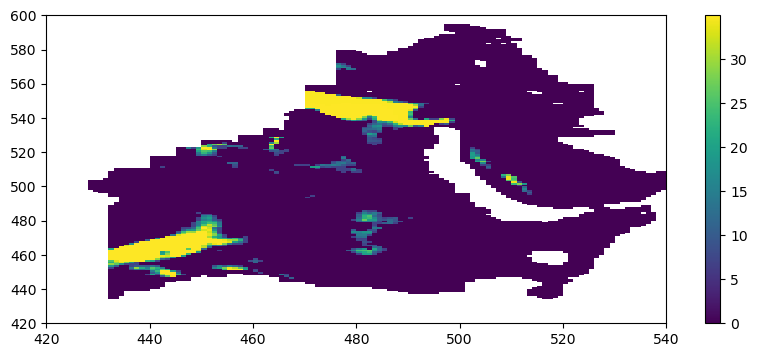

In [8]:
plt.pcolormesh(get_aste_tracer(SALTDR/drf3d*mymsk,nfx,nfy)[20])
plt.colorbar()
plt.xlim(420,540)
plt.ylim(420,600)

In [9]:
y_curr = [487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499,
       499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 500, 501, 502,
       503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515,
       515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515,
       515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 516, 517,
       518, 519, 520, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521,
       521, 521, 521, 521, 522, 523, 524, 525, 525, 525, 525, 525, 525,
       525, 525, 525, 525, 525]
x_curr = [146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 135, 135, 135,
       135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 110, 110,
       110, 110, 110,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109,  96,  96,  96,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95]

In [10]:
indices = np.arange(0,len(y_curr),1)


In [11]:
XV,YV= np.meshgrid(indices,mygrid['RC'])


(-600.0, 1.0)

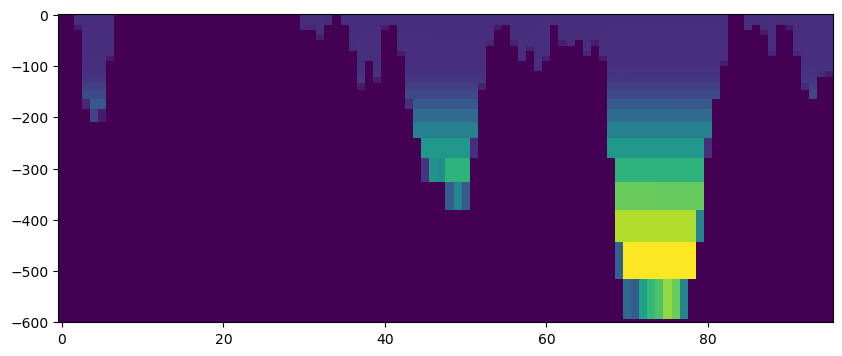

In [12]:
plt.pcolormesh(XV,YV,SALTDR[:,y_curr,x_curr])
plt.ylim(-600,1)

(400.0, 600.0)

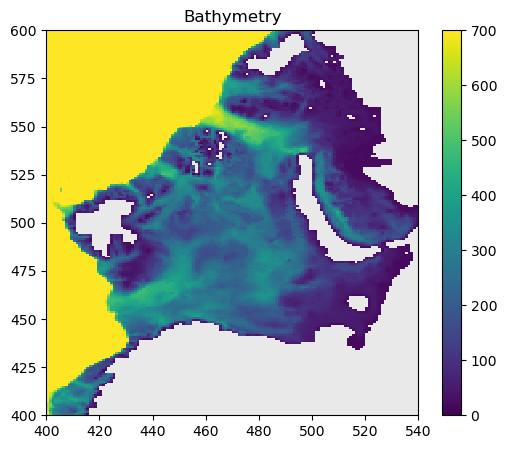

In [13]:
# try to plot the bathymetry to see how we're messing this up

landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan

fig = plt.figure(figsize = (6,5))
plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],vmax=700)
plt.colorbar()
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=.9,vmax=1.5)

# try to add gridlines with lat long based on XC and YC


plt.title("Bathymetry")
plt.xlim(400,540)
plt.ylim(400,600)

## Try to put two faces together for bathymetry without get_aste_tracer

nx 270
sz [1350  270]
(1, 1350, 270)
tmp (1, 450, 270)


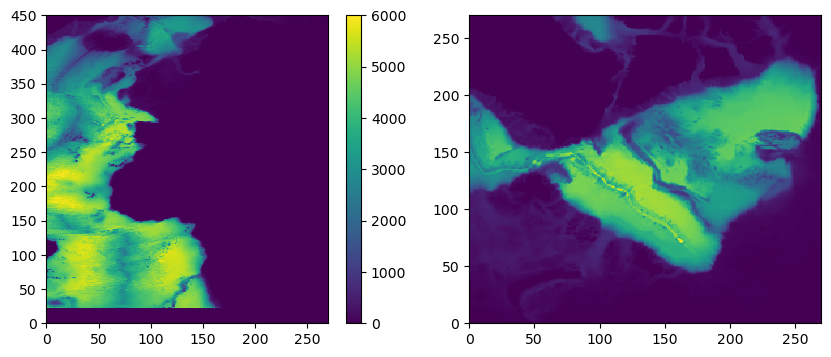

In [14]:
dep = mygrid['Depth']
dep_faces = get_aste_faces(dep,nfx,nfy)
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(dep_faces.f1[0])
plt.colorbar(cb)

ax = plt.subplot(122)
ax.pcolormesh(dep_faces.f3[0])

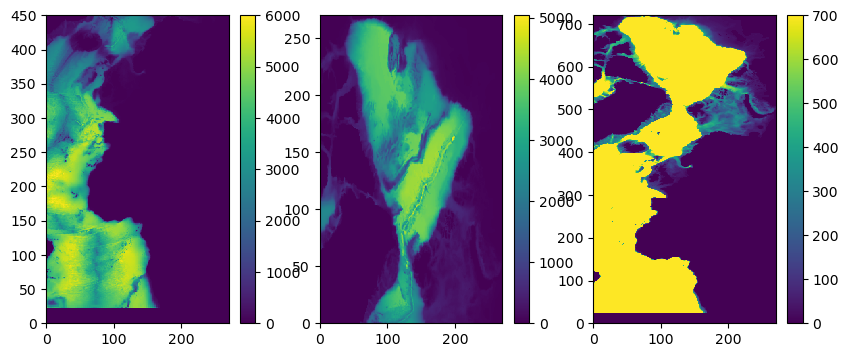

In [15]:
# now try to put these together
rotatedf3 = np.rot90(dep_faces.f3[0],3)
rotatedf3.shape

fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(dep_faces.f1[0])
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(np.rot90(dep_faces.f3[0],3))
plt.colorbar(cb)

ax = plt.subplot(133)
a = np.hstack((dep_faces.f1,rotatedf3.reshape(1,270,270)))[0]
cb = ax.pcolormesh(np.hstack((dep_faces.f1,rotatedf3.reshape(1,270,270)))[0],vmax=700)
plt.colorbar(cb)
# ax.set_xlim(150,270)
# ax.set_ylim(420,460)

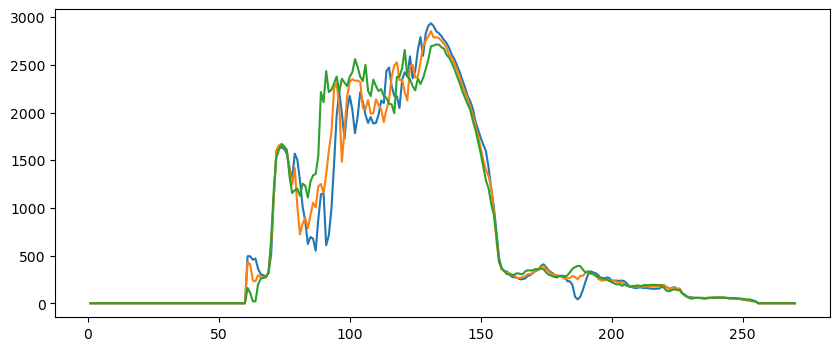

In [16]:
# we are putting the faces together correctly
b = np.arange(1,len(a[1])+1)
plt.plot(b,a[449],label=449)
plt.plot(b,a[450],label=450)
plt.plot(b,a[451],label=451)

## Try to look at horizontal convergence in mass

In [17]:
# copy our hconv, zconv, tendency at the gateway
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
tend = np.zeros((len(tsstr)-1,nz, ny, nx))
print(tend.shape)

for t in range(len(tsstr)-1):
    print(t)
    t1 = tsstr[t]
    t2 = tsstr[t+1]
    read = [int(t1),int(t2)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    SIheff,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])
    SIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[2])

    # do differencing
    dETAN_dt =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt  # change naming to dEtan_dt  m/s
    dSIheff_dt =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt
    dSIhsnow_dt = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt

    # choose by basin
    # select by existing basin in mskBasin
    dETAN_dt = np.reshape(dETAN_dt,(ny,nx)) #* mymsk
    dSIheff_dt = np.reshape(dSIheff_dt,(ny,nx)) #* mymsk
    dSIhsnow_dt = np.reshape(dSIhsnow_dt,(ny,nx)) #* mymsk

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmptend = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmptend[0,:, :] = dETAN_dt * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmptend[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC
            tmp2 = tmp1/mk3D_mod(DD,tmp1)
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)
            
        tmptend = tmp2 * mk3D_mod(dETAN_dt, tmp2) * myparms['rhoconst'] * mk3D_mod(RAC, hfC)    # kg/s

    tend[t,:,:,:] = tmptend

tend = tend[0]
# ds["mass_tend"] = xr.DataArray(data = tend, dims = dims3d_avg,coords = coords3d_avg)

(1, 50, 1350, 270)
0


In [18]:
# horizontal convergence terms for U and V mass
meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
varnames = np.array(['UVELMASS','VVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[0])       # m/s
VVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[1])       # m/s

UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)

In [19]:
tmpUo = myparms['rhoconst'] * dyg3d * drf3d * UVELMASS   # kg/s
tmpVo = myparms['rhoconst'] * dxg3d * drf3d * VVELMASS   # kg/s

tmpUoa,tmpVoa = get_aste_vector(UVELMASS,VVELMASS,nfx,nfy,False)

tmpUo_tracer = get_aste_tracer(tmpUo,nfx,nfy)
tmpVo_tracer = get_aste_tracer(tmpVo,nfx,nfy)


# this will not work because of how we've set up the faces, we want to stack these then do calcUVconv
budgO_fluxes_hconv = calc_UV_conv_1face(tmpUo, tmpVo)
print(budgO_fluxes_hconv.shape)

(50, 1350, 270)


In [20]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',51).copy()
cmap.set_under(color='white')

### Try not to use any premade function for this, just work from loaded data

In [27]:
UVELMASSvec,VVELMASSvec = get_aste_vector(UVELMASS,VVELMASS,nfx,nfy,True)

(400.0, 600.0)

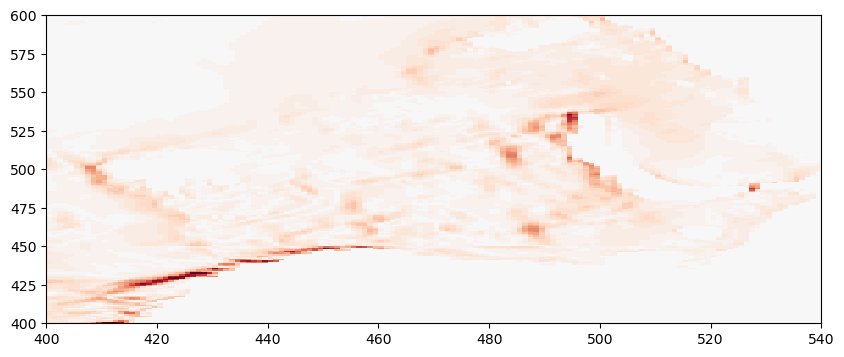

In [32]:
plt.pcolormesh(UVELMASSvec[0],vmin=-0.5,vmax=0.5,cmap=cmap)
plt.xlim(400,540)
plt.ylim(400,600)

In [21]:
import ecco_v4_py as ecco
ds = aste.get_dataset()
ds = ds.sel(time='2015-01')
ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)
grid = ecco.get_llc_grid(cds,domain='aste')
uvel,vvel = ecco.vector_calc.UEVNfromUXVY(ds['UVELMASS'],
                                                ds['VVELMASS'],
                                                coords=cds,
                                                grid=grid)

NameError: name 'aste' is not defined

In [ ]:
grid = ecco.get_llc_grid(cds,domain='aste')
uvel,vvel = ecco.vector_calc.UEVNfromUXVY(UVELMASS,
                                                VVELMASS,
                                                coords=cds,
                                                grid=grid)

nx 270
sz [  50 1350  270]
(50, 1350, 270)
tmp (50, 450, 270)


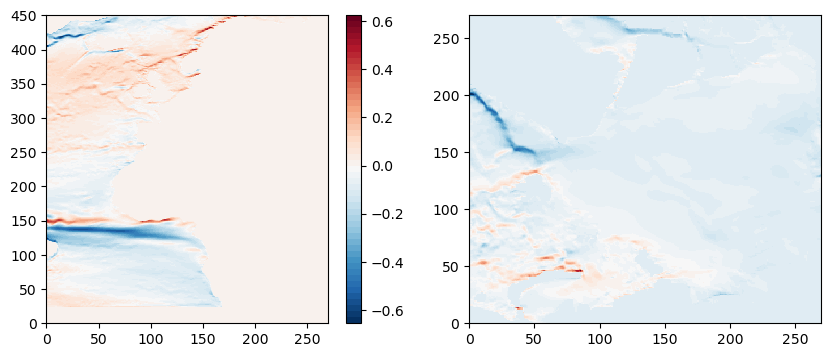

In [24]:
fldout = get_aste_faces(UVELMASS,nfx,nfy)
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(fldout.f1[0],cmap=cmap)
plt.colorbar(cb)

ax = plt.subplot(122)
cb = ax.pcolormesh(fldout.f3[0],cmap=cmap)

(50, 270, 270) (50, 450, 270)


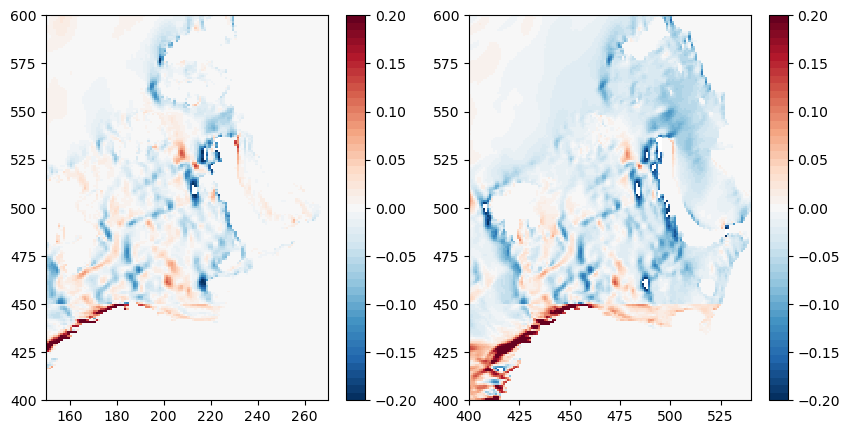

In [25]:
tmpUo_face1 = UVELMASS[:,0:nfy[0],0:nx]
tmpU = UVELMASS[:,nfy[0]:nfy[0]+nfy[2],0:nx]
tmpUo_face3=np.transpose(tmpU, (1,2,0))        #(270,270,nz)
tmpUo_face3=list(zip(*tmpUo_face3[::-1]))
tmpUo_face3=np.transpose(tmpUo_face3,[2,0,1])         #(nz,270,270)
print(tmpUo_face3.shape,tmpUo_face1.shape)

# tmp3 = np.array([np.rot90(layer, 3) for layer in tmpUo])

fig = plt.figure(figsize=(10,5))

ax = plt.subplot(121)
norm = TwoSlopeNorm(vmin=-0.2,vcenter=0,vmax=0.2)
cb = ax.pcolormesh(np.vstack((tmpUo_face1[10][:,:],-tmpUo_face3[10][:,:])),cmap=cmap,norm=norm)
plt.colorbar(cb)
ax.set_xlim(150,270)
ax.set_ylim(400,600)

ax = plt.subplot(122)
norm = TwoSlopeNorm(vmin=-0.2,vcenter=0,vmax=0.2)
cb = ax.pcolormesh(tmpUoa[0],cmap=cmap,norm=norm)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
plt.colorbar(cb)

(50, 270, 270) (50, 450, 270)


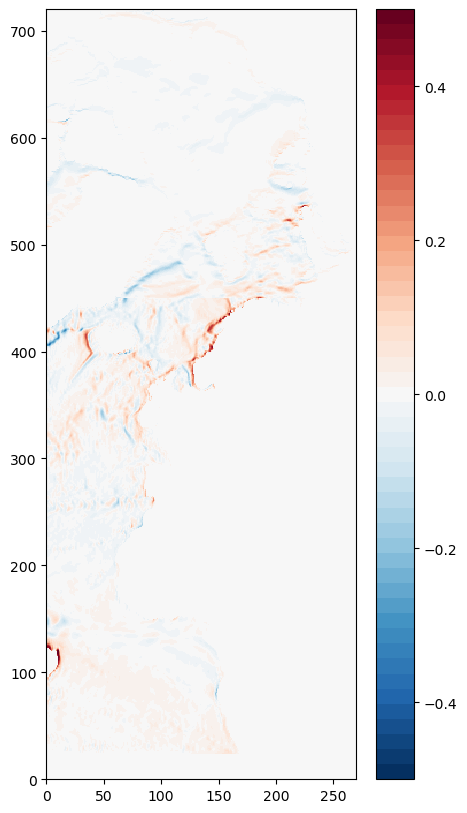

In [28]:
tmpUo_face1 = VVELMASS[:,0:nfy[0],0:nx]
tmpU = VVELMASS[:,nfy[0]:nfy[0]+nfy[2],0:nx]
tmpU=np.transpose(tmpU, (1,2,0))        #(270,270,nz)
tmpU=list(zip(*tmpU[::-1]))
tmpUo_face3=np.transpose(tmpU,[2,0,1])         #(nz,270,270)
print(tmpUo_face3.shape,tmpUo_face1.shape)

# tmp3 = np.array([np.rot90(layer, 3) for layer in tmpUo_face3])

fig = plt.figure(figsize=(5,10))
norm = TwoSlopeNorm(vmin=-0.5,vcenter=0,vmax=0.5)
plt.pcolormesh(np.vstack((tmpUo_face1[10][:,:],-tmpUo_face3[10][:,:])),cmap=cmap,norm=norm)
plt.colorbar()

In [162]:
# try for another hconv

file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),int(t2),returnmeta=True,rec=recs[3])

tmpUo = myparms['rcp'] * (ADVx_TH + DFxE_TH)
tmpVo = myparms['rcp'] * (ADVy_TH + DFyE_TH)

ADVx_TH = ADVx_TH.reshape(nz,ny,nx)
ADVy_TH = ADVy_TH.reshape(nz,ny,nx)

# ADVx_TH,ADVy_TH = get_aste_vector(ADVx_TH,ADVy_TH,nfx,nfy,False)

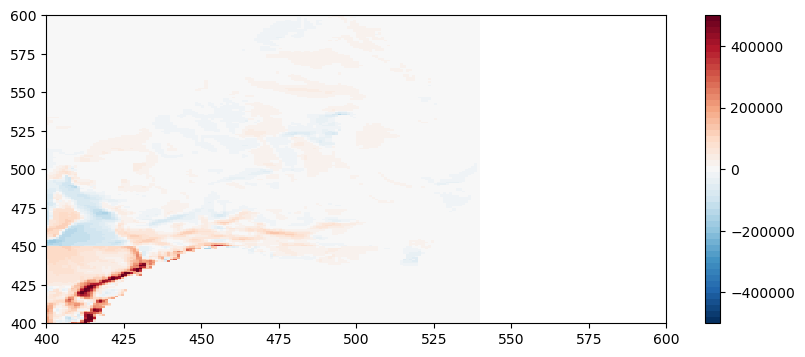

In [160]:
plt.pcolormesh(ADVy_TH[0],cmap=cmap,vmin=-500000,vmax=500000)
plt.xlim(400,600)
plt.ylim(400,600)
plt.colorbar()

(50, 270, 270) (50, 450, 270)


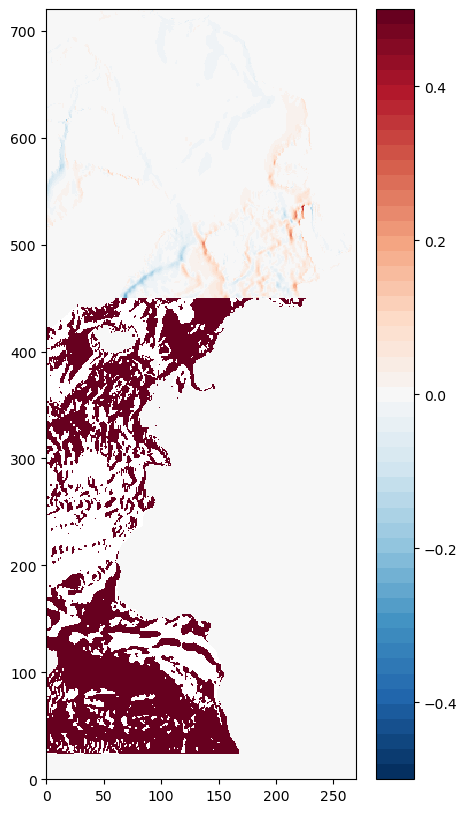

In [163]:
tmpUo_face1 = ADVy_TH[:,0:nfy[0],0:nx]
tmpU = ADVy_TH[:,nfy[0]:nfy[0]+nfy[2],0:nx]
tmpU=np.transpose(tmpU, (1,2,0))        #(270,270,nz)
tmpU=list(zip(*tmpU[::-1]))
tmpUo_face3=np.transpose(tmpU,[2,0,1])         #(nz,270,270)
print(tmpUo_face3.shape,tmpUo_face1.shape)

# tmp3 = np.array([np.rot90(layer, 3) for layer in tmpUo_face3])

fig = plt.figure(figsize=(5,10))
norm = TwoSlopeNorm(vmin=-0.5,vcenter=0,vmax=0.5)
plt.pcolormesh(np.vstack((tmpUo_face1[10][:,:],tmp3[10][:,:])),cmap=cmap,norm=norm)
plt.colorbar()

In [81]:
ETAN0 = ETAN[0].reshape(1350,270)

(270, 270) (450, 270)


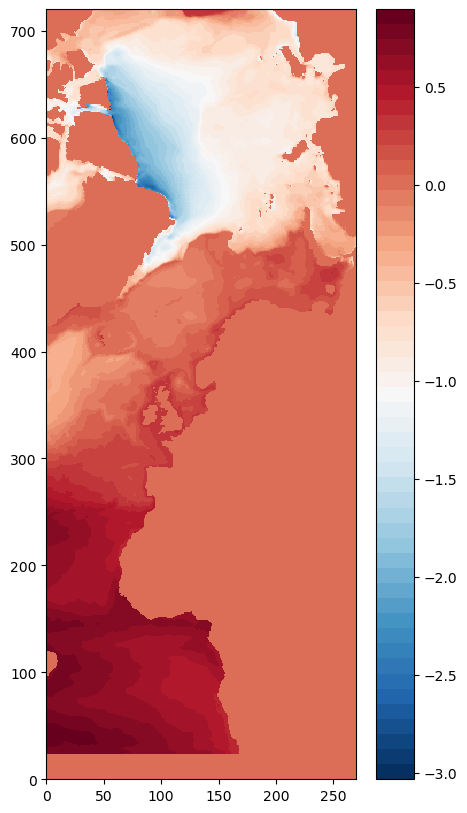

In [84]:
# try this with ETAN to see if it aligns with non vector data
tmpUo_face1 = ETAN0[0:nfy[0],0:nx]
tmpUo_face3 = ETAN0[nfy[0]:nfy[0]+nfy[2],0:nx]
print(tmpUo_face3.shape,tmpUo_face1.shape)

# tmp3 = np.array([np.rot90(layer, 3) for layer in tmpUo_face3])
tmp3 = np.rot90(tmpUo_face3, 3) #for layer in tmpUo_face3])
# print(tmp3.shape)

fig = plt.figure(figsize=(5,10))
norm = TwoSlopeNorm(vmin=-2e7,vcenter=0,vmax=2e7)
plt.pcolormesh(np.vstack((tmpUo_face1[:,:],tmp3[:,:])),cmap=cmap)
plt.colorbar()

#### Try to use get_aste_vector for these then do convergence

In [63]:
tmpUo2,tmpVo2 = get_aste_vector(tmpUo,tmpVo,nfx,nfy,False)
tmpUo2.shape

(50, 901, 541)

In [64]:
budgO_fluxes_hconv2 = calc_UV_conv_1face(tmpUo2, tmpVo2)

In [65]:
landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan
landmsk = get_aste_tracer(landmsk,nfx,nfy)[0]

(400.0, 550.0)

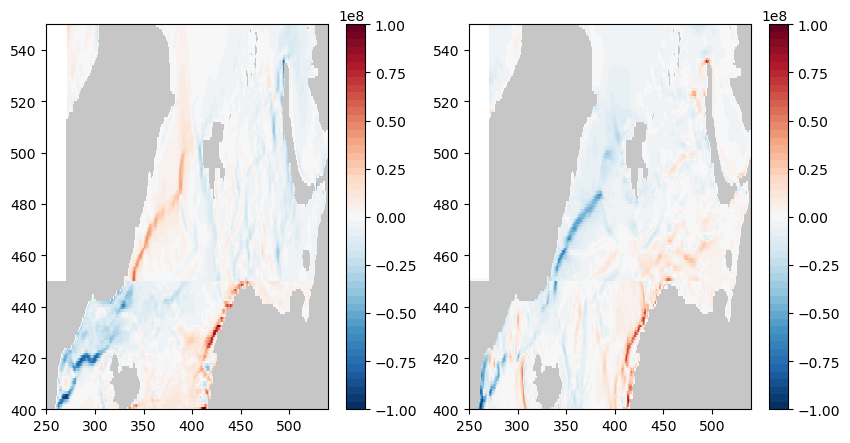

In [66]:
fig = plt.figure(figsize=(10,5))

ax = plt.subplot(121)
norm = TwoSlopeNorm(vmin=-1e8,vcenter=0,vmax=1e8)
# budgO_fluxes_hconv[0][449] *=0 
cb = ax.pcolormesh(tmpUo2[0],cmap=cmap,norm=norm)
plt.colorbar(cb)
ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2)
ax.set_xlim(250,540)
ax.set_ylim(400,550)

ax = plt.subplot(122)
norm = TwoSlopeNorm(vmin=-1e8,vcenter=0,vmax=1e8)
# budgO_fluxes_hconv[0][449] *=0 
cb = ax.pcolormesh(tmpVo2[0],cmap=cmap,norm=norm)
plt.colorbar(cb)
ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2)
ax.set_xlim(250,540)
ax.set_ylim(400,550)

(400.0, 600.0)

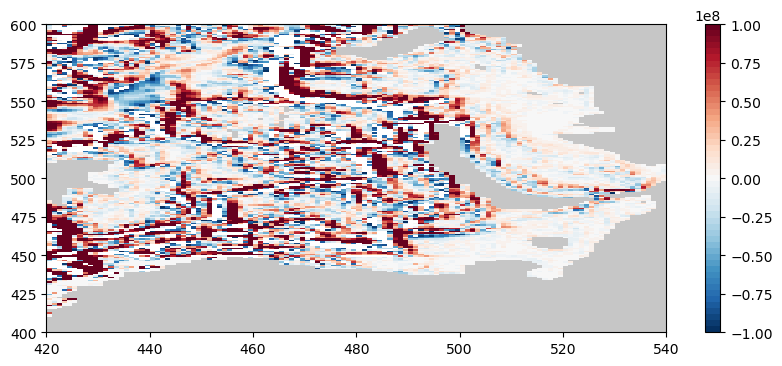

In [30]:
norm = TwoSlopeNorm(vmin=-1e8,vcenter=0,vmax=1e8)
# budgO_fluxes_hconv[0][449] *=0 
plt.pcolormesh(np.nansum(budgO_fluxes_hconv2,axis=0),cmap=cmap,norm=norm)
plt.colorbar()
plt.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2)
plt.xlim(420,540)
plt.ylim(400,600)

#### Try with doing convergence of each individually

In [31]:
tmpUo=get_aste_faces(tmpUo,nfx,nfy)
tmpVo=get_aste_faces(tmpVo,nfx,nfy)

nx 270
sz [  50 1350  270]
(50, 1350, 270)
tmp (50, 450, 270)
nx 270
sz [  50 1350  270]
(50, 1350, 270)
tmp (50, 450, 270)


In [32]:
rotatedf3.shape

(270, 270)

(400.0, 550.0)

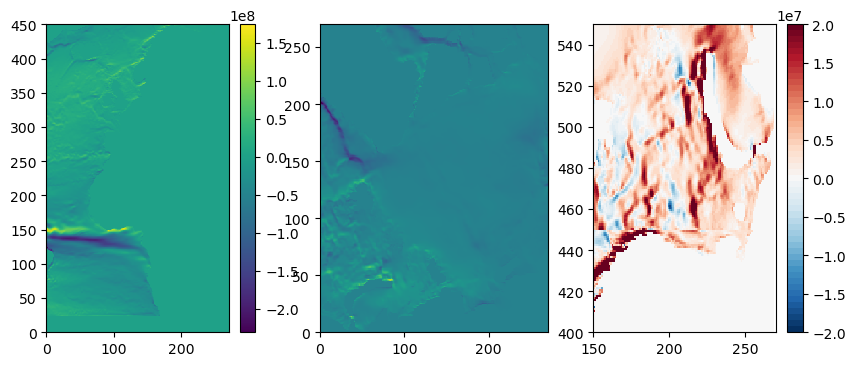

In [33]:
fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(tmpUo.f1[0])
plt.colorbar(cb)

ax = plt.subplot(132)
ax.pcolormesh(tmpUo.f3[0])

ax = plt.subplot(133)
rotatedf3 = np.rot90(tmpUo.f3[0],3)
norm = TwoSlopeNorm(vmin=-2e7,vcenter=0,vmax=2e7)
cb = ax.pcolormesh(np.vstack((tmpUo.f1[0][:,:-1],rotatedf3[:,1:])),cmap=cmap,norm=norm)
plt.colorbar(cb)
ax.set_xlim(150,270)
ax.set_ylim(400,550)

(400.0, 550.0)

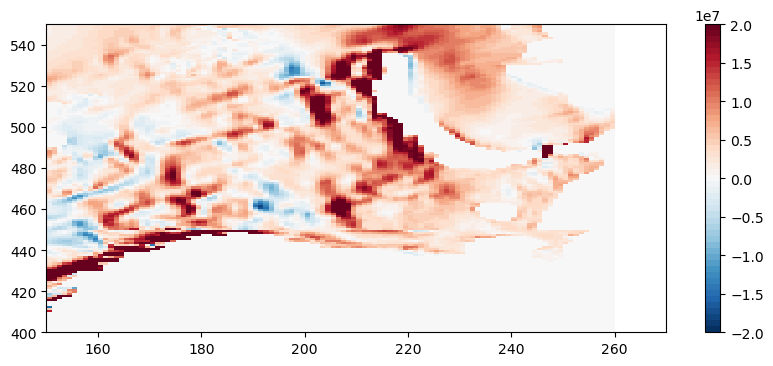

In [34]:
fig = plt.figure()
ax = plt.subplot(111)
rotatedf3 = np.rot90(tmpUo.f3[0],3)
norm = TwoSlopeNorm(vmin=-2e7,vcenter=0,vmax=2e7)
cb = ax.pcolormesh(np.vstack((tmpUo.f1[0][:,:-10],rotatedf3[:,10:])),cmap=cmap,norm=norm)
plt.colorbar(cb)
ax.set_xlim(150,270)
ax.set_ylim(400,550)

In [35]:
# get the faces from mskBasin so we can plot
mymsk = get_aste_faces(mskBasin,nfx,nfy)

nx 270
sz [1350  270]
(1, 1350, 270)
tmp (1, 450, 270)


In [36]:
rotatedf3 = np.rot90(mymsk.f3[0],3)
rotatedf3.shape
mymsk.f1.shape

(1, 450, 270)

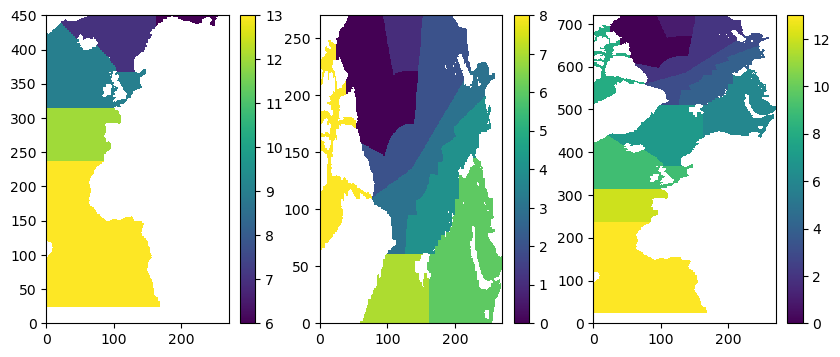

In [37]:
fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(mymsk.f1[0])
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(np.rot90(mymsk.f3[0],3))
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(np.hstack((mymsk.f1,rotatedf3.reshape(1,270,270)))[0])
plt.colorbar(cb)

In [38]:
bigmask = np.hstack((mymsk.f1,rotatedf3.reshape(1,270,270)))
mymsk = bigmask.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

10650


In [39]:
mymsk.shape

(1, 720, 270)

(400.0, 600.0)

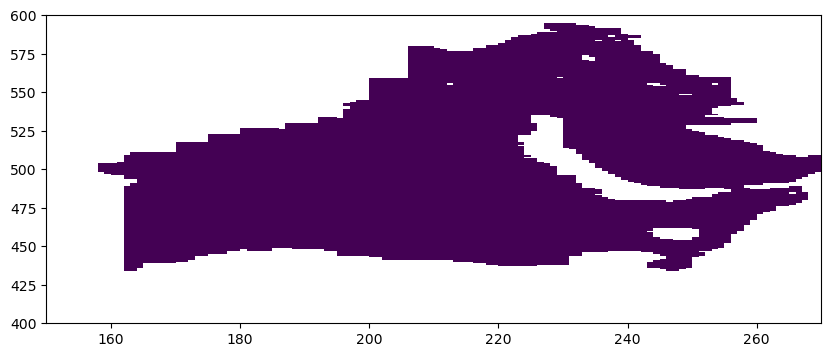

In [40]:
plt.pcolormesh(mymsk[0])
plt.xlim(150,270)
plt.ylim(400,600)

In [41]:
# now we can do the same method to calculate horizontal convergence
# rotatedf3 = np.rot90(mymsk.f3[0],3)
tmpUo.f3.shape
rotated_tmpUof3 = np.array([np.rot90(layer, 3) for layer in tmpUo.f3])
rotated_tmpVof3 = np.array([np.rot90(layer, 3) for layer in tmpVo.f3])

rotated_tmpUof3.shape

tmpUo1 = np.hstack((tmpUo.f1[:-3],rotated_tmpUof3[3:]))   # CHANGE
tmpVo1 = np.hstack((tmpVo.f1[:-3],rotated_tmpVof3[3:]))

budgO_fluxes_hconv = calc_UV_conv_1face(tmpUo1, tmpVo1)

(400.0, 600.0)

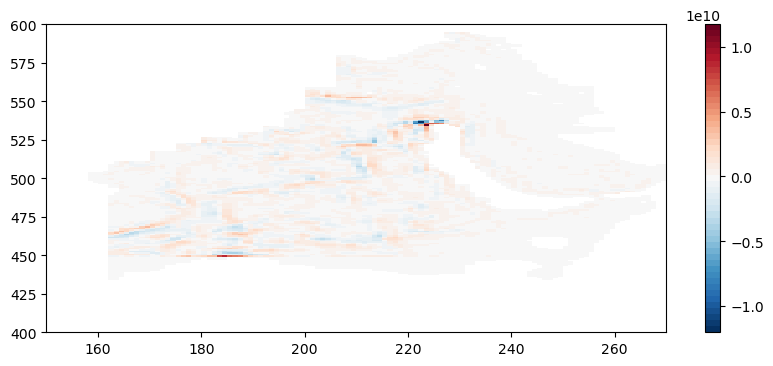

In [42]:
norm = TwoSlopeNorm(vmin=-1e8,vcenter=0,vmax=1e8)
# budgO_fluxes_hconv[0][449] *=0 
plt.pcolormesh(np.nansum(budgO_fluxes_hconv,axis=0)*mymsk[0],cmap=cmap)
plt.colorbar()
plt.xlim(150,270)
plt.ylim(400,600)

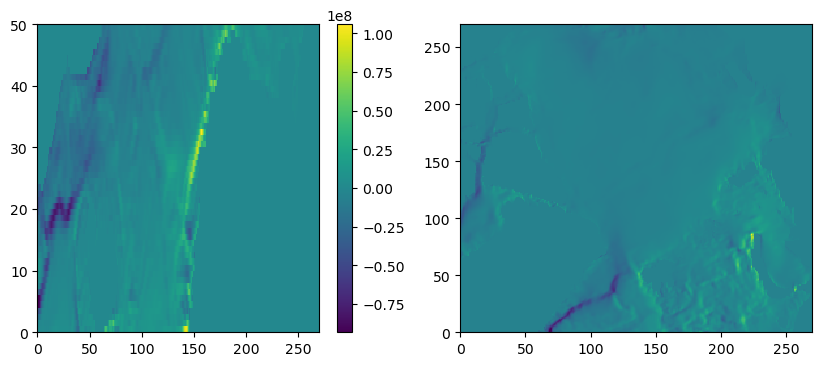

In [43]:
# this still looks wrong at 450 - let's try to get convergence at one grid box
# let's get the row at the boundary for both faces
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(tmpUo.f1[0][400:])
plt.colorbar(cb)

ax = plt.subplot(122)
ax.pcolormesh(np.rot90(tmpUo.f3[0], 3))

In [44]:
a = tmpUo.f1[0,-2]  # top layer of face 1
b = np.rot90(tmpUo.f3[0], 3)[0]  # bottom layer of face 3

In [45]:
# I wonder if we can do the horizontal convergence on the faces separately then put them together
try1 = calc_UV_conv_1face(tmpUo.f1,tmpVo.f1)
try2 = calc_UV_conv_1face(tmpUo.f3,tmpVo.f3)

# calculate the conv individually at the boundary
f1_last_columnU = tmpUo.f1[:,-1,:][:, np.newaxis, :]  # Shape: (50, 1, 270)
f3_first_columnU = rotated_tmpUof3[:,0,:][:, np.newaxis, :]  # Shape: (50, 1, 270)  # this should also be rotated
bstackU = np.concatenate((f1_last_columnU, f3_first_columnU), axis=1)  # Shape: (50, 2, 270)
bstackU.shape

f1_last_column = tmpVo.f1[:,-1,:][:, np.newaxis, :]  # Shape: (50, 1, 270)
f3_first_column = rotated_tmpVof3[:,0,:][:, np.newaxis, :]  # Shape: (50, 1, 270)   # this should be rotated
bstackV = np.concatenate((f1_last_column, f3_first_column), axis=1)  # Shape: (50, 2, 270)
bstackV.shape

(50, 2, 270)

In [46]:
rotated_try2 = np.array([np.rot90(layer, 3) for layer in try2])

try3_hconv = np.hstack((try1,rotated_try2))

In [47]:
try3_hconv.shape

(50, 720, 270)

In [48]:
try3 = calc_UV_conv_1face(bstackU,bstackV)

(400.0, 600.0)

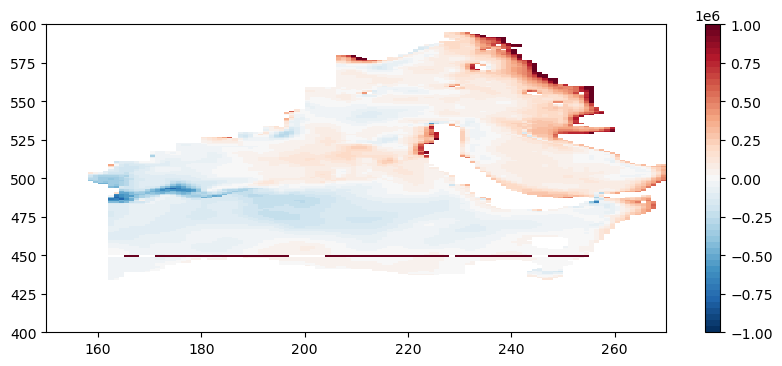

In [49]:
norm = TwoSlopeNorm(vmin=-1000000,vcenter=0,vmax=1000000)
try3_hconv[:,449] = try3[:,0]
plt.pcolormesh(np.nansum(try3_hconv,axis=0)*mymsk[0],cmap=cmap,norm=norm)
plt.colorbar()
plt.xlim(150,270)
plt.ylim(400,600)

In [50]:
f1_last_columnU.shape

(50, 1, 270)

In [51]:
for i,j in zip(f1_last_columnU[0,0],f3_first_columnU[0,0]):
    print(i,j)

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -10688873.295006376
-6980233.667570497 -8996155.019519053
-14390678.804151108 -4661599.918399106
-18068977.791745577 -3681619.5295503847
-18320400.831974506 -4971612.308078598
-16029589.288085472 -10051521.008840058
-12986428.685212836 -15754866.054971121
-13657096.425971186 -38254363.14472517
-16880449.741482392 -57168466.99769871
-13979868.83155705 -52840467.675436914
-9877171.316077935 -29903775.807554357
-9732941.092228416 -13240551.689011747
-10148120.631860537 -8122100.227123283
-10242898.70765216 -568677

In [52]:
for i,j in zip(tmpUo.f1[0][100],tmpVo.f1[0][100]):
    print(i,j)

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 478563.4121386541
3989893.397419901 -51365086.10612332
-21323566.162856843 -119432743.59591696
-77180290.1394418 -81097803.82705401
-69288577.45461874 -96364332.6703126
-55985920.12000309 -80394435.66134611
-17137416.249573376 12582132.410867743
-2892502.4147357587 16158149.97258
-9379427.965400537 -25192804.118076272
-8018251.388663997 -40119510.22984009
2961621.848002524 -18676353.42694307
13548413.013641728 -291012.63037279405
12564520.47448907 -5100672.838532418
4624240.71628671 -21164488.778598096
-2491770.190447833 -32191700.137194075
-7262221.324621607 -29032010.429759633
-10846701.571401274 -22298139.783891484
-11563060.95334961 -15784326.46680483
-13609410.137432866 -15611071.985499201
-17331986.242905956 -23916972.5770306
-18381821.32151269 -26279260.60142613
-17425911.426177416 -22654370.599363748
-14372391.961972464 -18978418.705391783
-11806348.90474468 -12641511.263139741
-11787826.268314917 -10127956.248281162
-11258926.798901659 -1433